In [ ]:
#| hide
#| default_exp optimize
from nbdev import *

# Sampling optimizer

> The post-processing procedure to fit the sampling set to the target distribution. This code is an implementation of the clever idea by Janek Łażewski to replace crude weighting produced by the Metropolis-Hastings algorithm by weights derived directly from the PDF of the target distribution. This idea makes the acceptance ratio essentially 100% and allows nice tricks like changing of the target distribution (e.g. shifting of the target temperature of the sample or even scanning of the temperature range using prior distribution generated using `plan_T_scan`).

In [ ]:
#| hide
#| exporti
from numpy import log, exp, sqrt, linspace, dot
from scipy import stats
from scipy.special import expit
from matplotlib import pylab as plt
import ase
import ase.units as un
from ase.build import bulk
from spglib import find_primitive, get_symmetry_dataset
import spglib
from tqdm.auto import tqdm
from hecss.util import select_asap_model
from hecss.monitor import plot_stats
from hecss.planner import plan_T_scan
import numpy as np
import itertools 

In [ ]:
#| exporti
flatten = itertools.chain.from_iterable

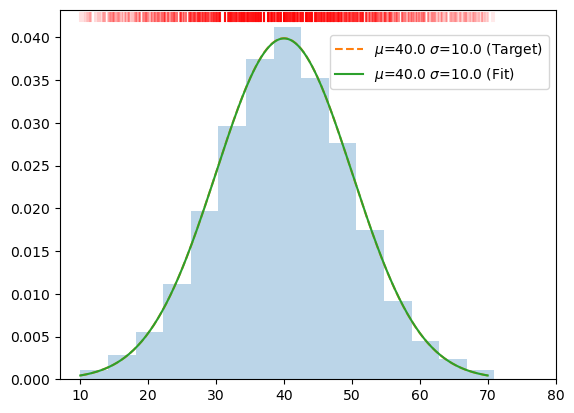

In [ ]:
def refit(data, mu, sigma, sigma_scale=1.0, N=None, Nb=None):
    '''
    Re-shaper of the data distribution
    '''
    # Data multiplication factor
    if N is None:
        N = 10*len(data)
    
    # Target distribution
    # You can use slightly (5% for N=10*len(data)) smaller sigma 
    # to compensate for the missing tails below weight=1
    g = stats.norm(mu, sigma_scale*sigma)
    d = np.sort(data)
    # bw = d[2:]-d[:-2]
    # bp = (d[2:]+d[:-2])/2
    
    # Make bins for PDF evaluation
    # Each data point gets its own bin by splitting 
    # the distance between data points in half.
    # The boundary points get symmetrical bins.
    bw = np.zeros(d.shape)
    bp = np.zeros(d.shape)
    # Internal points
    bp[:-1] = (d[1:] + d[:-1])/2
    bw[1:-1] = bp[1:-1] - bp[:-2]
    # Boundary points
    bw[0] = d[1]-d[0]
    bw[-1] = d[-1]-d[-2]
    bp[1:-1] = (bp[0:-2] + bp[1:-1])/2
    bp[0] = d[0]
    bp[-1] = d[-1]
    
    # Data weights to fit the target distribution
    w = g.pdf(bp)*bw
    w /= w.sum()
    nf = N
    
    # Block zero weights in the +/- 3*sigma zone to not lose data
    iw = np.round(w*nf) + (1*(np.abs(d - mu) < 3*sigma))
    # Weight the data by multiplication of data points
    wd = list(flatten([int(ww)*[dd] for ww, dd in zip(iw,d) if ww>=1]))

    if Nb is None :
        Nb = min(len(data)//4, 15)
        
    h, b, _ = plt.hist(wd, bins=Nb, density=True, alpha=0.3);
    x = np.linspace(mu-3*sigma, mu+3*sigma, 300)
    fit = stats.norm.fit(wd)
    plt.plot( x, stats.norm.pdf(x, mu, sigma), '--', label=f'$\mu$={mu:.1f} $\sigma$={sigma:.1f} (Target)' )
    plt.plot( x, stats.norm.pdf(x, *fit), label=f'$\mu$={fit[0]:.1f} $\sigma$={fit[1]:.1f} (Fit)' )
    skip = len(d)//2000
    skip = int(max(1, skip))
    nf = (iw[::skip]).max()
    for s, a in zip(d[::skip], iw[::skip]):
        if a<1e-3:
            continue
        plt.axvline(s, ymin=0.97, ymax=0.99, ls='-', color='r', alpha=np.sqrt(a/nf))
    
    return w, iw, wd

N = 1_000
d = np.sort(stats.uniform.rvs(0, 100, size=N))
plt.hist(d, bins='auto', density=True);
skip = len(d)//2000
skip = int(max(1, skip))
for s in d[::skip]:
    plt.axvline(s, ymin=0.95, ymax=0.98, ls='-', color='r', alpha=0.2)              
m = 40
s = 10
fw, iw, wd = refit(d, m, s, 0.95, 10*len(d))
plt.xlim(None, m+4*s)
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95));

In [ ]:
iw[iw>0].sum(), len(wd), len(iw[iw>0])

(10588.0, 10588, 612)

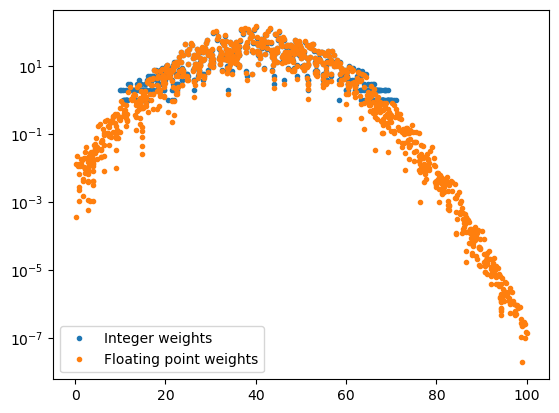

In [ ]:
plt.semilogy()
plt.plot(d[iw>0], iw[iw>0], '.', label='Integer weights')
plt.plot(d, len(wd)*fw, '.', label='Floating point weights')
plt.legend();

In [ ]:
#| asap

from ase.build import bulk
from ase.spacegroup import crystal
from hecss.monitor import plot_stats, plot_virial_stat, plot_xs_stat
from hecss.monitor import plot_acceptance_history, plot_dofmu_stat
from hecss.util import select_asap_model, create_asap_calculator
from hecss.core import HECSS

In [ ]:
#| asap

model = select_asap_model('SiC')
print(f'Using potential model: {model}')

sys_size = '1x1x1'
sys_size = '2x2x2'
sys_size = '3x3x3'
sys_size = '4x4x4'
sys_size = '5x5x5'
sc = [int(v) for v in sys_size.split('x')]
cryst = bulk('SiC', crystalstructure='zincblende',
                 a=4.38120844, cubic=True).repeat(tuple(sc))
cryst.set_calculator(create_asap_calculator(model))

Using potential model: MEAM_LAMMPS_KangEunJun_2014_SiC__MO_477506997611_000


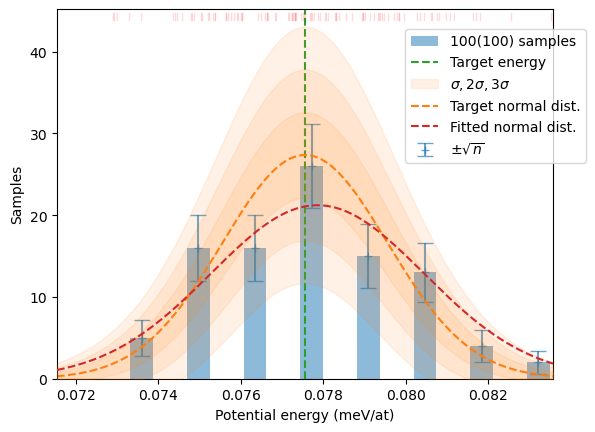

In [ ]:
#| asap

T = 600
N = 100
hecss = HECSS(cryst, lambda : create_asap_calculator(model), pbar=False)
hecss.estimate_width_scale(10, Tmax=1000)
smpls = [s for s in hecss._sampler(T, N)]
plot_stats(smpls, T, sqrN=True, show=False)
plt.savefig('AUX/hecss.pdf', bbox_inches='tight')

In [ ]:
#| export
def make_sampling(data, T, sigma_scale=1.0, N=None, 
                  nonzero_w=False, debug=False, N_bins=None):
    if N is None:
        N = 4*len(data)
    if N_bins is None :
        N_bins = min(len(data)//4, 15)
    # Use slightly (10%) wider sigma to compensate 
    # for the missing tails below weight=1
    nat = data[0][2].shape[0]
    mu = 3*T*un.kB/2
    sigma = np.sqrt(3/2)*un.kB*T/np.sqrt(nat)   

    g = stats.norm(mu, sigma_scale*sigma)
    e = np.fromiter((s[-1] for s in data), float)
    idx = np.argsort(e)
    ridx = np.arange(len(idx))[idx]
    d = e[idx]
    if debug:
        # print(idx.shape, d.shape, mu-sigma, 2*sigma)
        mh = plt.hist(d, bins=N_bins, density=False)[0].max()
        
        plt.plot(d, 1.1*mh*np.ones(d.shape), '|', alpha=max(0.01, min(1.0, 100/len(d))))
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.title('Raw data')
        plt.show()
    # bw = d[2:]-d[:-2]
    # bp = (d[2:]+d[:-2])/2
    bw = np.zeros(d.shape)
    bp = np.zeros(d.shape)
    bp[:-1] = (d[1:] + d[:-1])/2
    bw[1:-1] = bp[1:-1] - bp[:-2]
    bw[0] = d[1]-d[0]
    bw[-1] = d[-1]-d[-2]
    bp[1:-1] = (bp[0:-2] + bp[1:-1])/2
    bp[0] = d[0]
    bp[-1] = d[-1]

    w = g.pdf(bp)*bw
    # w = stats.uniform.pdf(bp, mu-sigma, 2*sigma)*bw
    w /= w.sum()
    nf = N

    if debug:
        plt.plot(bp, w, '.')
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.plot(bp, 2*np.cumsum(w)/len(w), '.')
        x = linspace(e.min(), e.max(), 100)
        plt.plot(x, 2*g.cdf(x)/len(w), '-')
        plt.axhline(2/len(w), ls=':', color='k', lw=1)
        plt.title('Data weights')
        plt.show()
        plt.hist(d, weights=w, bins=N_bins, density=True)
        plt.title('Weighted data (without nonzero_w)')
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.show()
    
    # Block zero weights in the +/- 3*sigma zone to not lose data
    w = np.round(w*nf) 
    if nonzero_w:
        w += (1*(np.abs(d - mu) < 3*sigma))
    
    # wdi = np.fromiter(flatten(int(ww)*[ii] for ww, ii in zip(w,ridx[1:-1]) if ww>=1), int)
    # wd = [data[i] for i in wdi]
    # wde = d[wdi]
    wd = []
    for ww, ii in zip(w,idx):
        if ww<1:
            continue
        wd += int(ww)*[data[ii]]
    # print(len(wd), wde.shape)
    # assert len(wd) == N
    if debug:
        wde = np.fromiter((s[-1] for s in wd), float)
        h, b, _ = plt.hist(wde, bins=N_bins, density=True, alpha=0.3);
        # assert h.sum() == len(wde)
        x = np.linspace(mu-3*sigma, mu+3*sigma, 300)
        fit = stats.norm.fit(wde)
        plt.plot( x, stats.norm.pdf(x, mu, sigma), '--', 
                 label=f'$\mu$={2*mu/3/un.kB:.1f}; $\sigma$={2*sigma/3/un.kB:.1f} (Target)' )
        plt.plot( x, stats.norm.pdf(x, *fit), 
                 label=f'$\mu$={2*fit[0]/3/un.kB:.1f}; $\sigma$={2*fit[1]/3/un.kB:.1f} (Fit)' )
        plt.title('Generated weighted sample')
        skip = len(d)//2000
        skip = int(max(1, skip))
        print(skip)
        nf = (w[::skip]).max()
        for s, a in zip(d[::skip], w[::skip]):
            if a<1e-3:
                continue
            plt.axvline(s, ymin=0.95, ymax=0.99, ls='-', color='r', alpha=np.sqrt(a/nf))
        plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95));
    return wd

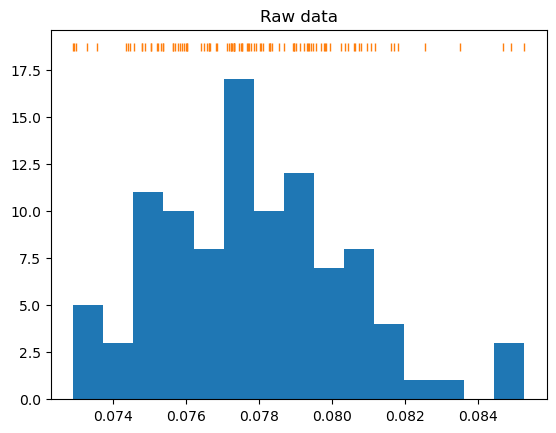

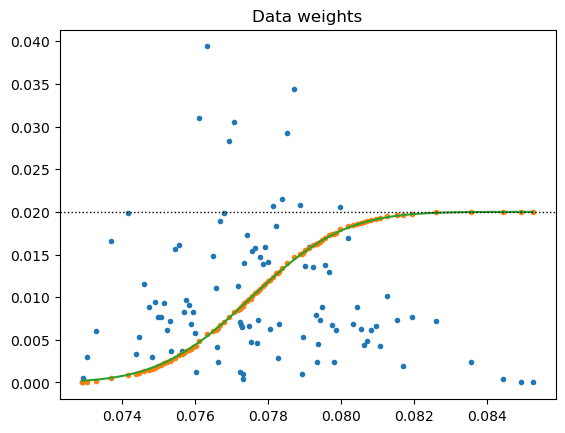

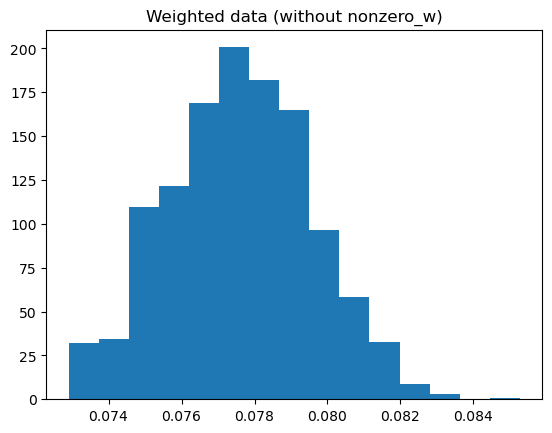

1


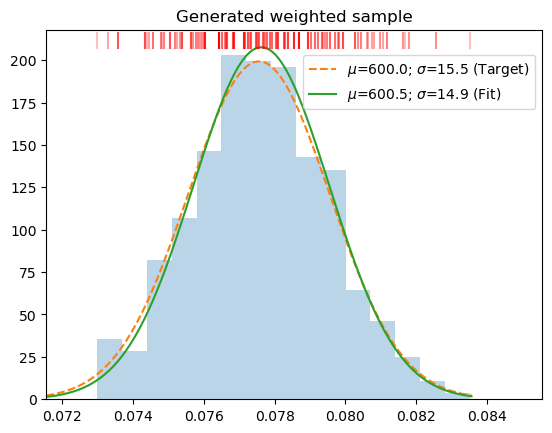

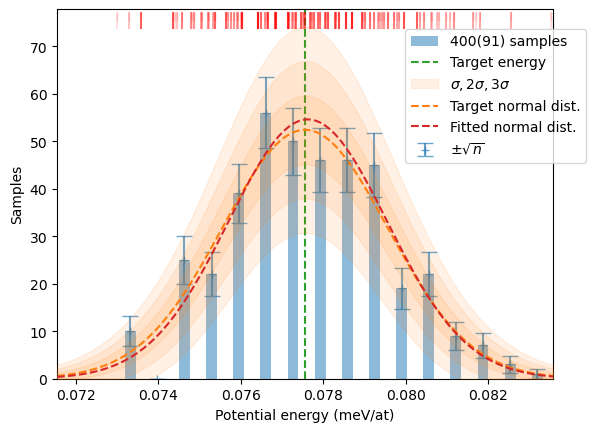

In [ ]:
#| asap

wd = make_sampling(smpls, T, debug=True)
plt.show()
plot_stats(wd, T, sqrN=True, show=False)
skip = max(1, len(wd)//2000)
alpha = min(1,50*skip/len(wd))
for s in wd[::skip]:
    plt.axvline(s[-1], ymin=0.95, ymax=0.99, ls='-', color='r', alpha=alpha)
plt.savefig('AUX/hecss_opt.pdf', bbox_inches='tight')

In [ ]:
#| export
def get_sample_weights(data, T, Nb=None, nonzero_w=False, debug=False):

    if Nb is None :
        Nb = min(len(data)//4, 15)
    
    nat = data[0][2].shape[0]
    mu = 3*T*un.kB/2
    sigma = np.sqrt(3/2)*un.kB*T/np.sqrt(nat)   

    g = stats.norm(mu, sigma)
    e = np.fromiter((s[-1] for s in data), float)
    idx = np.argsort(e)
    ridx = np.arange(len(idx))[idx]
    d = e[idx]
    if debug:
        # print(idx.shape, d.shape, mu-sigma, 2*sigma)
        mh = plt.hist(d, bins=Nb, density=False)[0].max()
        plt.plot(d, 1.1*mh*np.ones(d.shape), '|')
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.title('Raw data')
        plt.show()
    
    bw = np.zeros(d.shape)
    bp = np.zeros(d.shape)
    bp[:-1] = (d[1:] + d[:-1])/2
    bw[1:-1] = bp[1:-1] - bp[:-2]
    bw[0] = d[1]-d[0]
    bw[-1] = d[-1]-d[-2]
    bp[1:-1] = (bp[0:-2] + bp[1:-1])/2
    bp[0] = d[0]
    bp[-1] = d[-1]
    w = g.pdf(bp)*bw
    # w = stats.uniform.pdf(bp, mu-sigma, 2*sigma)*bw
    w /= w.sum()

    if debug:
        plt.plot(d, w, '.')
        # plt.plot(bp, w, '|')
        # plt.step(d, w, where='mid')
        plt.plot(bp, 2*np.cumsum(w)/len(w), '.')
        x = linspace(e.min(), e.max(), 100)
        plt.plot(x, 2*g.cdf(x)/len(w), '-')
        plt.axhline(2/len(w), ls=':', color='k', lw=1)
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.title('Data weights')
        plt.show()
        plt.hist(d, weights=w, bins=Nb, density=False)
        plt.title('Weighted data (without nonzero_w)')
        # plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.show()
    
    # Block zero weights in the +/- 3*sigma zone to not lose data
    if nonzero_w:
        w += (nonzero_w*w.mean()*(np.abs(d[1:-1] - mu) < 3*sigma))
    
    # wdi = np.fromiter(flatten(int(ww)*[ii] for ww, ii in zip(w,ridx[1:-1]) if ww>=1), int)
    # wd = [data[i] for i in wdi]
    # wde = d[wdi]
    # wd = []
    # for ww, ii in zip(w,idx[1:-1]):
    #     if ww<1:
    #         continue
    #     wd += int(ww)*[data[ii]]
    # print(len(wd), wde.shape)
    # assert len(wd) == N
    if debug:
        
        def get_stats(d, w):
            m = np.average(d, weights=w)
            s = np.sqrt(np.average((d - m)**2, weights=w))
            return m, s
        
        # wde = np.fromiter((s[-1] for s in data), float)
        h, b, _ = plt.hist(d, weights=w, bins=Nb, density=True, alpha=0.3);
        x = np.linspace(mu-3*sigma, mu+3*sigma, 300)
        fit = get_stats(d, w)
        plt.plot( x, stats.norm.pdf(x, mu, sigma), '--', 
                 label=f'$\mu$={2*mu/3/un.kB:.1f}; $\sigma$={2*sigma/3/un.kB:.1f} (Target)' )
        plt.plot( x, stats.norm.pdf(x, *fit), 
                 label=f'$\mu$={2*fit[0]/3/un.kB:.1f}; $\sigma$={2*fit[1]/3/un.kB:.1f} (Fit)' )
        plt.title('Final weighted data')
        skip = len(d)//2000
        skip = int(max(1, skip))
        # print(skip)
        nf = (w[::skip]).max()
        for s, a in zip(d[1:-1:skip], w[::skip]):
            if a<1e-3:
                continue
            plt.axvline(s, ymin=0.95, ymax=0.99, ls='-', color='r', alpha=np.sqrt(a/nf))
        plt.xlim(mu-3*sigma, mu+4*sigma)
        plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95));
    return w

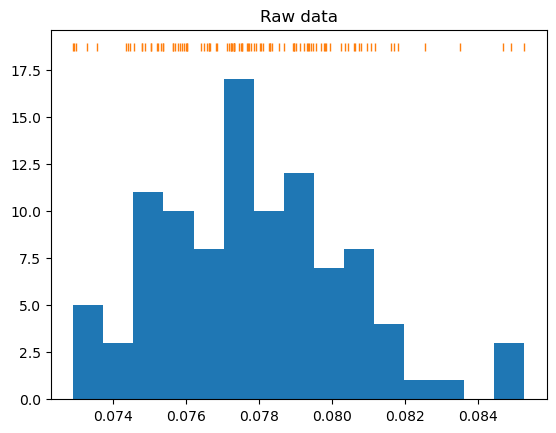

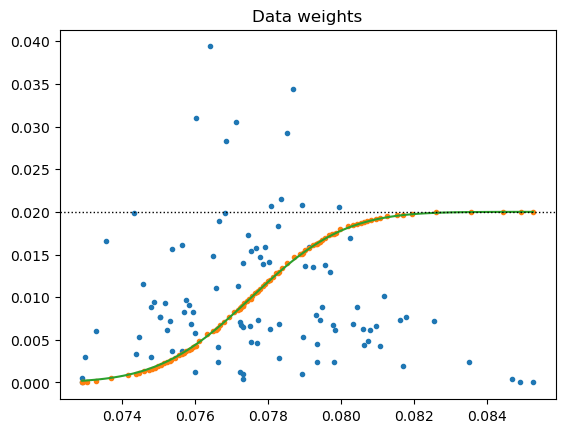

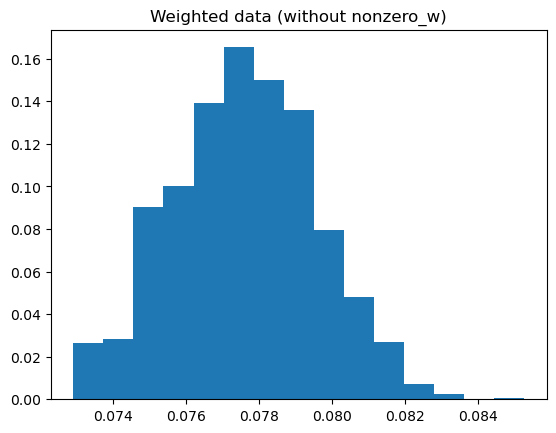

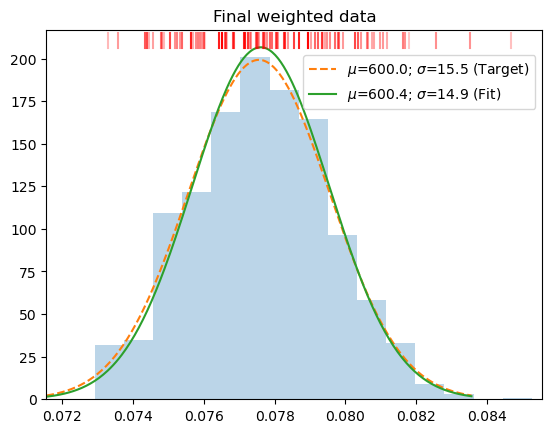

In [ ]:
#| asap

wgh =  get_sample_weights(smpls, T, nonzero_w=0, debug=True)

In [ ]:
#| asap

uni = {}
N = 1000
for T in 275, 300, 325:
    uni[T]=[s for s in hecss._sampler(T, N)]

In [ ]:
#| asap

e_dist = {t:np.array([s[-1] for s in d]) for t, d in uni.items()}
e_uni = np.concatenate(tuple(e_dist.values()))
usmp = []
for s in uni.values():
    usmp += s

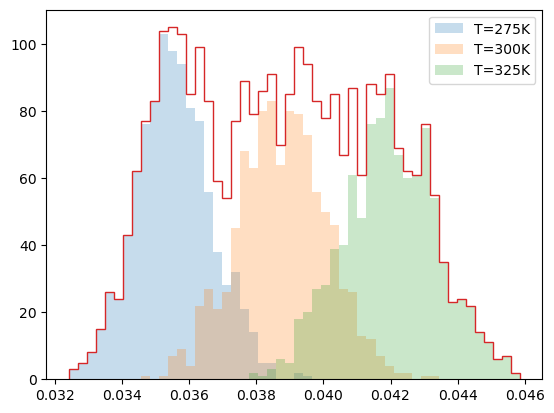

In [ ]:
#| asap

for T, ed in e_dist.items():
    plt.hist(ed, bins=50, label=f'{T=}K', alpha=0.25, range=(e_uni.min(), e_uni.max()))
plt.hist(e_uni, bins=50, histtype='step', stacked=True, range=(e_uni.min(), e_uni.max()))
plt.legend();

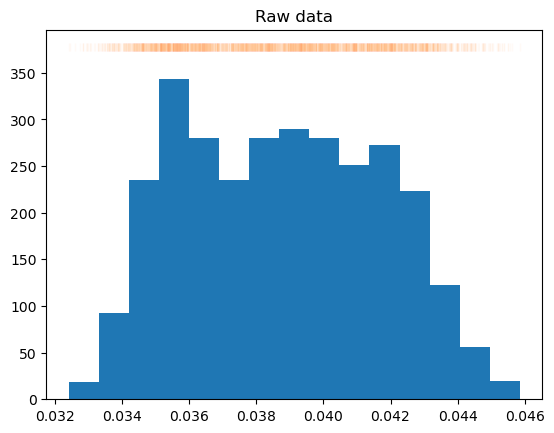

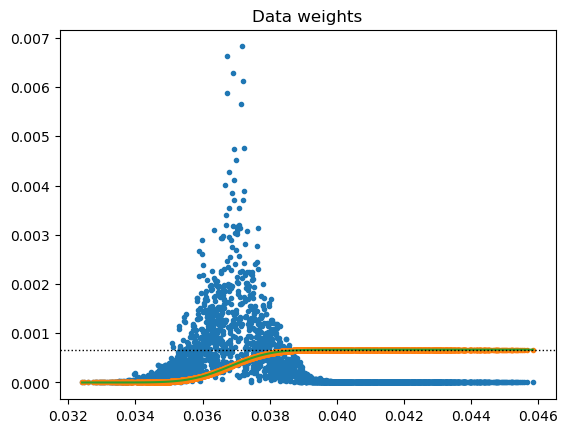

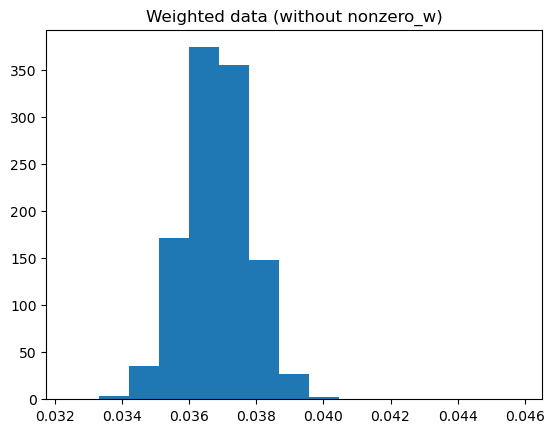

1
3000 11942


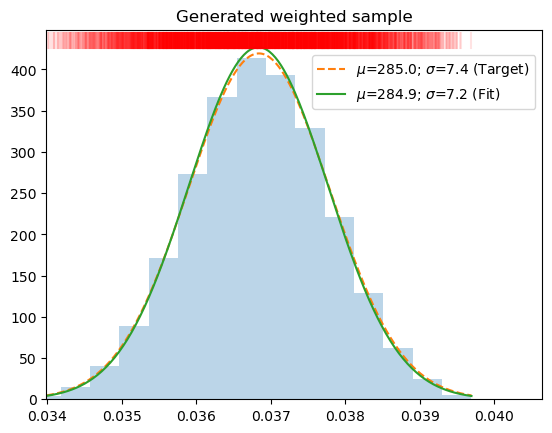

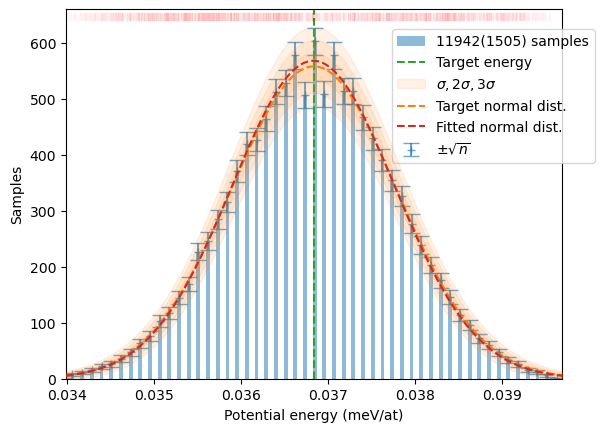

In [ ]:
#| asap

T = 285
wd = make_sampling(usmp, T, nonzero_w=False, debug=True)
print(len(usmp), len(wd))
plt.legend(loc='upper right', bbox_to_anchor=(1.0, 0.95))
plt.show();
plot_stats(wd, T, sqrN=True, show=False)
plt.savefig(f'AUX/T_fit_{T=:.0f}K.pdf', bbox_inches='tight')